In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

from astropy import units as u
import astropy 
from scipy.interpolate import interp1d

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import igm

import gc, linecache, glob, re

plt.rcParams['figure.figsize'] = (13,13)
plt.rcParams['font.size'] = 22

plt.rcParams.update({'font.size': 22, 'text.usetex': True})
plt.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def int_formatter(x,pos):
    return format(x, 'd')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
intfmt  = FuncFormatter(int_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [3]:
gc.collect()

45

In [4]:
np.set_printoptions(linewidth=100)
labelsize=20

# Load Schaerer

In [5]:
# jwstFilters   = lf.loadJWSTFilters(suppress=True)
# hubbleFilters = lf.loadHubbleFilters(suppress=True)
# jhkFilters    = lf.loadJHKFilters(suppress=True)

lamRange      = np.logspace(1.95,5.7,5500)

schaererPath = '/Users/earnric/OneDrive/Software-Models/Schaerer/'
schaererDirs = ['pop3_TA/','pop3_TE/','e-70_mar08/','e-50_mar08/']
# schaererDirs = ['pop3_TAtest/']
Zs           = [0.0, 0.0, 1.0e-7, 1.0e-5]
schaererPopFilePattern  = 'pop3_ge0_log?_500_001_is5.[0-9]*' # is5 files have ages in step of 1 Myr
schaererLowZFilePattern = 'e-?0_sal_100_001_is2.[0-9]*'      # is2 files have ages in step of 0.05 dex

# Load the schaerer files... 
# Note that due to spacing (in age), there are sometimes two files that 
# are SEDS for the same time-stamp! Skip the second one (and third!)
lastAge = 0.0
for i, (Z, schaererDir) in enumerate(zip(Zs,schaererDirs)):
    if schaererDir.startswith('pop3'):
        schaererFilePattern = schaererPath + schaererDir + schaererPopFilePattern  # Pop III files, 1 Myr spacing
    else:
        schaererFilePattern = schaererPath + schaererDir + schaererLowZFilePattern # Low Z files, 0.05 dex spacing

    schaererFiles   = glob.glob(schaererFilePattern)  # All the files in the dir... 
    schaererFiles   = [a for a in schaererFiles if not re.search('\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
    schaererAges    = [linecache.getline(file,13) for file in schaererFiles]    # Get the line with the (log) age... 
    schaererAges    = np.array([float(sa[30:]) for sa in schaererAges],dtype=float)         # Log age starts at position 30

    schaererData    = np.array([np.loadtxt(file,skiprows=16) for file in schaererFiles])
    ageSortIndxes   = schaererAges.argsort()          # Array of indices to sort things by age...
    
    schaererData    = schaererData[ageSortIndxes]
    schaererAges    = schaererAges[ageSortIndxes]
    print(schaererAges)

    # Ignore data files with the same age! This occurs in the popIII dirs
    # because the timestep is smaller than the age-resolution printed in the file
    # Hence we get 2 files with different data but the same time stamp
    lastAge = 0.0
    schaererDataGood = []
    schaererAgesGood = []
    for ii,(sd,age) in enumerate(zip(schaererData,schaererAges)):
        if age == lastAge:
            # Remove it
            continue
        lastAge = age
        schaererDataGood.append(sd)
        schaererAgesGood.append(float(age))
    
    # The following builds an array of arrays (one for each age) with each array's entries:
    # log age, Z, waveln, lum/A
    allSchaererData = [np.insert(sed[:,[0,2]],[0],[[anAge] for ii in range(0,len(sed))], axis=1) 
        for anAge,sed in zip(schaererAgesGood, schaererDataGood)]
    allSchaererData = np.array(allSchaererData).reshape(len(allSchaererData)*len(allSchaererData[0]),3)
    if i == 0:
        pop3TA = allSchaererData # may need a np.copy(...) here... ??
    elif i == 1:
        pop3TE = allSchaererData
    elif i == 2:
        Zem7 = allSchaererData
    elif i == 3:
        Zem5 = allSchaererData
    # We now have:
    # [[log age, waveln, flux], [], ...]

[ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
[ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
[ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55
  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35
  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.
  8.05  8.1   8.15  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75  8.8
  8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35  9.4   9.45  9.5   9.55]
[ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55
  5.6   5.65  5.7   5.75  5.8  

In [6]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
SB99Path = '/Users/earnric/OneDrive/Software-Models/STARBURST99/STARBURST99-runs/' # Home computer dir... 
SB99Dirs = ['padova0004-op/','padova004-op/','padova008-op/','padova02-op/'] # Dense SED (in age)
Zs       = [0.0004, 0.004, 0.008, 0.02]
SB99FilePat = 'padova*.spectrum1'

# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
for i, (Z, SB99Dir) in enumerate(zip(Zs,SB99Dirs)):
    SB99FilePattern = SB99Path + SB99Dir + SB99FilePat 
    SB99Files   = glob.glob(SB99FilePattern)  # All the files in the dir... should be one!
    if len(SB99Files) != 1:
        print('Error: too many files in an SB99 dir! - ',SB99Path + SB99Dir)
        sys.exit()
    SB99Data    = np.loadtxt(SB99Files[0],skiprows=6)
    if i == 0:
        SB990004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 1:
        SB99004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 2:
        SB99008 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 3:
        SB9902 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    # We now have:
    # [[log age, waveln, flux], [], ...]


In [7]:
SB990004_ages      = SB990004[:,0]
SB990004_wavelns   = SB990004[:,1] * u.Angstrom
SB990004_LperA     = SB990004[:,2] * u.erg / u.second / u.angstrom

SB99004_ages      = SB99004[:,0]
SB99004_wavelns   = SB99004[:,1] * u.Angstrom
SB99004_LperA     = SB99004[:,2] * u.erg / u.second / u.angstrom

SB99008_ages      = SB99008[:,0]
SB99008_wavelns   = SB99008[:,1] * u.Angstrom
SB99008_LperA     = SB99008[:,2] * u.erg / u.second / u.angstrom

SB9902_ages      = SB9902[:,0]
SB9902_wavelns   = SB9902[:,1] * u.Angstrom
SB9902_LperA     = SB9902[:,2] * u.erg / u.second / u.angstrom

In [8]:
pop3TA_ages    = pop3TA[:,0]
pop3TA_wavelns = pop3TA[:,1] * u.Angstrom
pop3TA_LperA   = pop3TA[:,2] * u.erg / u.second / u.angstrom

pop3TE_ages    = pop3TE[:,0]
pop3TE_wavelns = pop3TE[:,1] * u.Angstrom
pop3TE_LperA   = pop3TE[:,2] * u.erg / u.second / u.angstrom

Zem7_ages    = Zem7[:,0]
Zem7_wavelns = Zem7[:,1] * u.Angstrom
Zem7_LperA   = Zem7[:,2] * u.erg / u.second / u.angstrom

Zem5_ages    = Zem5[:,0]
Zem5_wavelns = Zem5[:,1] * u.Angstrom
Zem5_LperA   = Zem5[:,2] * u.erg / u.second / u.angstrom


In [9]:
print("Ages I want ",np.log10([1e6,5e6,1e7,2e7,5e7,1e8]))

('Ages I want ', array([ 6.     ,  6.69897,  7.     ,  7.30103,  7.69897,  8.     ]))


In [10]:
np.unique(pop3TE_ages)[0:33],np.unique(Zem5_ages)[40:80]

(array([ 4.   ,  6.004,  6.303,  6.479,  6.603,  6.7  ,  6.779,  6.846,  6.904,  6.955,  7.   ,
         7.042,  7.08 ,  7.114,  7.146,  7.176,  7.204,  7.231,  7.256,  7.279,  7.301,  7.322,
         7.343,  7.362,  7.38 ,  7.398,  7.415,  7.432,  7.447,  7.463,  7.477,  7.492,  7.505]),
 array([ 6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,  6.3 ,  6.35,  6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,
         6.65,  6.7 ,  6.75,  6.8 ,  6.85,  6.9 ,  6.95,  7.  ,  7.05,  7.1 ,  7.15,  7.2 ,  7.25,
         7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,  7.55,  7.6 ,  7.65,  7.7 ,  7.75,  7.8 ,  7.85,  7.9 ,
         7.95]))

In [11]:
pop3TE_LperA[pop3TE_ages == 6.004],pop3TE_LperA[pop3TE_ages == 6.7],pop3TE_LperA[pop3TE_ages == 7.],pop3TE_LperA[pop3TE_ages == 7.301],pop3TE_LperA[pop3TE_ages == 7.699],pop3TE_LperA[pop3TE_ages == 8.]

(<Quantity [  1.17870000e+34,  1.27460000e+34,  1.37356000e+34,...,   1.72139000e+22,
              1.13524000e+22,  7.49425000e+21] erg / (Angstrom s)>,
 <Quantity [  3.80859000e+23,  8.41003000e+23,  1.72481000e+24,...,   1.20615000e+21,
              7.96263000e+20,  5.26312000e+20] erg / (Angstrom s)>,
 <Quantity [  1.17958000e+21,  2.48153000e+21,  5.23286000e+21,...,   1.65609000e+20,
              1.09107000e+20,  7.20580000e+19] erg / (Angstrom s)>,
 <Quantity [  3.65775000e+18,  6.72379000e+18,  1.23605000e+19,...,   2.18228000e+19,
              1.44255000e+19,  9.54552000e+18] erg / (Angstrom s)>,
 <Quantity [  1.24090000e+14,  2.58235000e+14,  5.37392000e+14,...,   2.90459000e+18,
              1.91275000e+18,  1.26518000e+18] erg / (Angstrom s)>,
 <Quantity [  3.41913000e+00,  1.26835000e+01,  4.70638000e+01,...,   7.26043000e+17,
              4.68789000e+17,  3.07174000e+17] erg / (Angstrom s)>)

In [12]:
pop3TE_wl   = {1: pop3TE_wavelns[pop3TE_ages == 6.004], 5: pop3TE_wavelns[pop3TE_ages == 6.7], 10: pop3TE_wavelns[pop3TE_ages == 7.]
           , 20: pop3TE_wavelns[pop3TE_ages == 7.301], 50: pop3TE_wavelns[pop3TE_ages == 7.699], 100: pop3TE_wavelns[pop3TE_ages == 8.]}
pop3TE_flux = {1: pop3TE_LperA[pop3TE_ages == 6.004], 5: pop3TE_LperA[pop3TE_ages == 6.7] , 10: pop3TE_LperA[pop3TE_ages == 7.] 
           , 20: pop3TE_LperA[pop3TE_ages == 7.301] , 50: pop3TE_LperA[pop3TE_ages == 7.699] , 100: pop3TE_LperA[pop3TE_ages == 8.] }

In [13]:
pop3TE_wl

{1: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 5: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 10: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 20: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 50: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 100: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>}

In [14]:
pop3TA_wl   = {1: pop3TA_wavelns[pop3TA_ages == 6.004], 5: pop3TA_wavelns[pop3TA_ages == 6.7], 10: pop3TA_wavelns[pop3TA_ages == 7.]
           , 20: pop3TA_wavelns[pop3TA_ages == 7.301], 50: pop3TA_wavelns[pop3TA_ages == 7.699], 100: pop3TA_wavelns[pop3TA_ages == 8.]}
pop3TA_flux = {1: pop3TA_LperA[pop3TA_ages == 6.004], 5: pop3TA_LperA[pop3TA_ages == 6.7] , 10: pop3TA_LperA[pop3TA_ages == 7.] 
           , 20: pop3TA_LperA[pop3TA_ages == 7.301] , 50: pop3TA_LperA[pop3TA_ages == 7.699] , 100: pop3TA_LperA[pop3TA_ages == 8.] }

In [15]:
pop3TA_wl

{1: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 5: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 10: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 20: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 50: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>,
 100: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
              1.40000000e+06,  1.60000000e+06] Angstrom>}

In [16]:
zem5_wl   = {1:Zem5_wavelns[Zem5_ages == 6.0], 5:Zem5_wavelns[Zem5_ages == 6.7], 10:Zem5_wavelns[Zem5_ages == 7.0], 
           20:Zem5_wavelns[Zem5_ages == 7.3], 50:Zem5_wavelns[Zem5_ages == 7.7], 100:Zem5_wavelns[Zem5_ages == 8.0]}
zem5_flux = {1:Zem5_LperA[Zem5_ages == 6.0], 5:Zem5_LperA[Zem5_ages == 6.7], 10:Zem5_LperA[Zem5_ages == 7.0], 
           20:Zem5_LperA[Zem5_ages == 7.3], 50:Zem5_LperA[Zem5_ages == 7.7], 100:Zem5_LperA[Zem5_ages == 8.0]}
zem7_wl   = {1:Zem7_wavelns[Zem7_ages == 6.0], 5:Zem7_wavelns[Zem7_ages == 6.7], 10:Zem7_wavelns[Zem7_ages == 7.0], 
           20:Zem7_wavelns[Zem7_ages == 7.3], 50:Zem7_wavelns[Zem7_ages == 7.7], 100:Zem7_wavelns[Zem7_ages == 8.0]}
zem7_flux = {1:Zem7_LperA[Zem7_ages == 6.0], 5:Zem7_LperA[Zem7_ages == 6.7], 10:Zem7_LperA[Zem7_ages == 7.0], 
           20:Zem7_LperA[Zem7_ages == 7.3], 50:Zem7_LperA[Zem7_ages == 7.7], 100:Zem7_LperA[Zem7_ages == 8.0]}

In [17]:
zem5_wl,zem7_wl

({1: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  5: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  10: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  20: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  50: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  100: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>},
 {1: <Quantity [  9.09000000e+01,  9.35000000e+01,  9.61000000e+01,...,   1.20000000e+06,
          

In [18]:
SB9902_wl   = {1:SB9902_wavelns[SB9902_ages == 6.0043213737826422], 5:SB9902_wavelns[SB9902_ages == 6.6998377258672459], 10:SB9902_wavelns[SB9902_ages == 7.0004340774793183], 
           20:SB9902_wavelns[SB9902_ages == 7.3012470886362113], 50:SB9902_wavelns[SB9902_ages == 7.6990568545476679], 100:SB9902_wavelns[SB9902_ages == 8.0000434272768626]}
SB9902_flux = {1:SB9902_LperA[SB9902_ages == 6.0043213737826422], 5:SB9902_LperA[SB9902_ages == 6.6998377258672459], 10:SB9902_LperA[SB9902_ages == 7.0004340774793183], 
           20:SB9902_LperA[SB9902_ages == 7.3012470886362113], 50:SB9902_LperA[SB9902_ages == 7.6990568545476679], 100:SB9902_LperA[SB9902_ages == 8.0000434272768626]}

In [19]:
SB99004_wl   = {1:SB990004_wavelns[SB990004_ages == 6.0043213737826422], 5:SB990004_wavelns[SB990004_ages == 6.6998377258672459], 10:SB990004_wavelns[SB990004_ages == 7.0004340774793183], 
           20:SB990004_wavelns[SB990004_ages == 7.3012470886362113], 50:SB990004_wavelns[SB990004_ages == 7.6990568545476679], 100:SB990004_wavelns[SB990004_ages == 8.0000434272768626]}
SB99004_flux = {1:SB990004_LperA[SB990004_ages == 6.0043213737826422], 5:SB990004_LperA[SB990004_ages == 6.6998377258672459], 10:SB990004_LperA[SB990004_ages == 7.0004340774793183], 
           20:SB990004_LperA[SB990004_ages == 7.3012470886362113], 50:SB990004_LperA[SB990004_ages == 7.6990568545476679], 100:SB990004_LperA[SB990004_ages == 8.0000434272768626]}

In [20]:
SB990004_wl   = {1:SB990004_wavelns[SB990004_ages == 6.0043213737826422], 5:SB990004_wavelns[SB990004_ages == 6.6998377258672459], 10:SB990004_wavelns[SB990004_ages == 7.0004340774793183], 
           20:SB990004_wavelns[SB990004_ages == 7.3012470886362113], 50:SB990004_wavelns[SB990004_ages == 7.6990568545476679], 100:SB990004_wavelns[SB990004_ages == 8.0000434272768626]}
SB990004_flux = {1:SB990004_LperA[SB990004_ages == 6.0043213737826422], 5:SB990004_LperA[SB990004_ages == 6.6998377258672459], 10:SB990004_LperA[SB990004_ages == 7.0004340774793183], 
           20:SB990004_LperA[SB990004_ages == 7.3012470886362113], 50:SB990004_LperA[SB990004_ages == 7.6990568545476679], 100:SB990004_LperA[SB990004_ages == 8.0000434272768626]}

In [21]:
SB99008_wl   = {1:SB99008_wavelns[SB99008_ages == 6.0043213737826422], 5:SB99008_wavelns[SB99008_ages == 6.6998377258672459], 10:SB99008_wavelns[SB99008_ages == 7.0004340774793183], 
           20:SB99008_wavelns[SB99008_ages == 7.3012470886362113], 50:SB99008_wavelns[SB99008_ages == 7.6990568545476679], 100:SB99008_wavelns[SB99008_ages == 8.0000434272768626]}
SB99008_flux = {1:SB99008_LperA[SB99008_ages == 6.0043213737826422], 5:SB99008_LperA[SB99008_ages == 6.6998377258672459], 10:SB99008_LperA[SB99008_ages == 7.0004340774793183], 
           20:SB99008_LperA[SB99008_ages == 7.3012470886362113], 50:SB99008_LperA[SB99008_ages == 7.6990568545476679], 100:SB99008_LperA[SB99008_ages == 8.0000434272768626]}

In [22]:
SB9902_wl,SB99008_flux

({1: <Quantity [  9.10000000e+01,  9.40000000e+01,  9.60000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  5: <Quantity [  9.10000000e+01,  9.40000000e+01,  9.60000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  10: <Quantity [  9.10000000e+01,  9.40000000e+01,  9.60000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  20: <Quantity [  9.10000000e+01,  9.40000000e+01,  9.60000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  50: <Quantity [  9.10000000e+01,  9.40000000e+01,  9.60000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>,
  100: <Quantity [  9.10000000e+01,  9.40000000e+01,  9.60000000e+01,...,   1.20000000e+06,
               1.40000000e+06,  1.60000000e+06] Angstrom>},
 {1: <Quantity [  1.09587243e+22,  3.72571817e+22,  8.37355737e+22,...,   5.60905889e+28,
          

27399

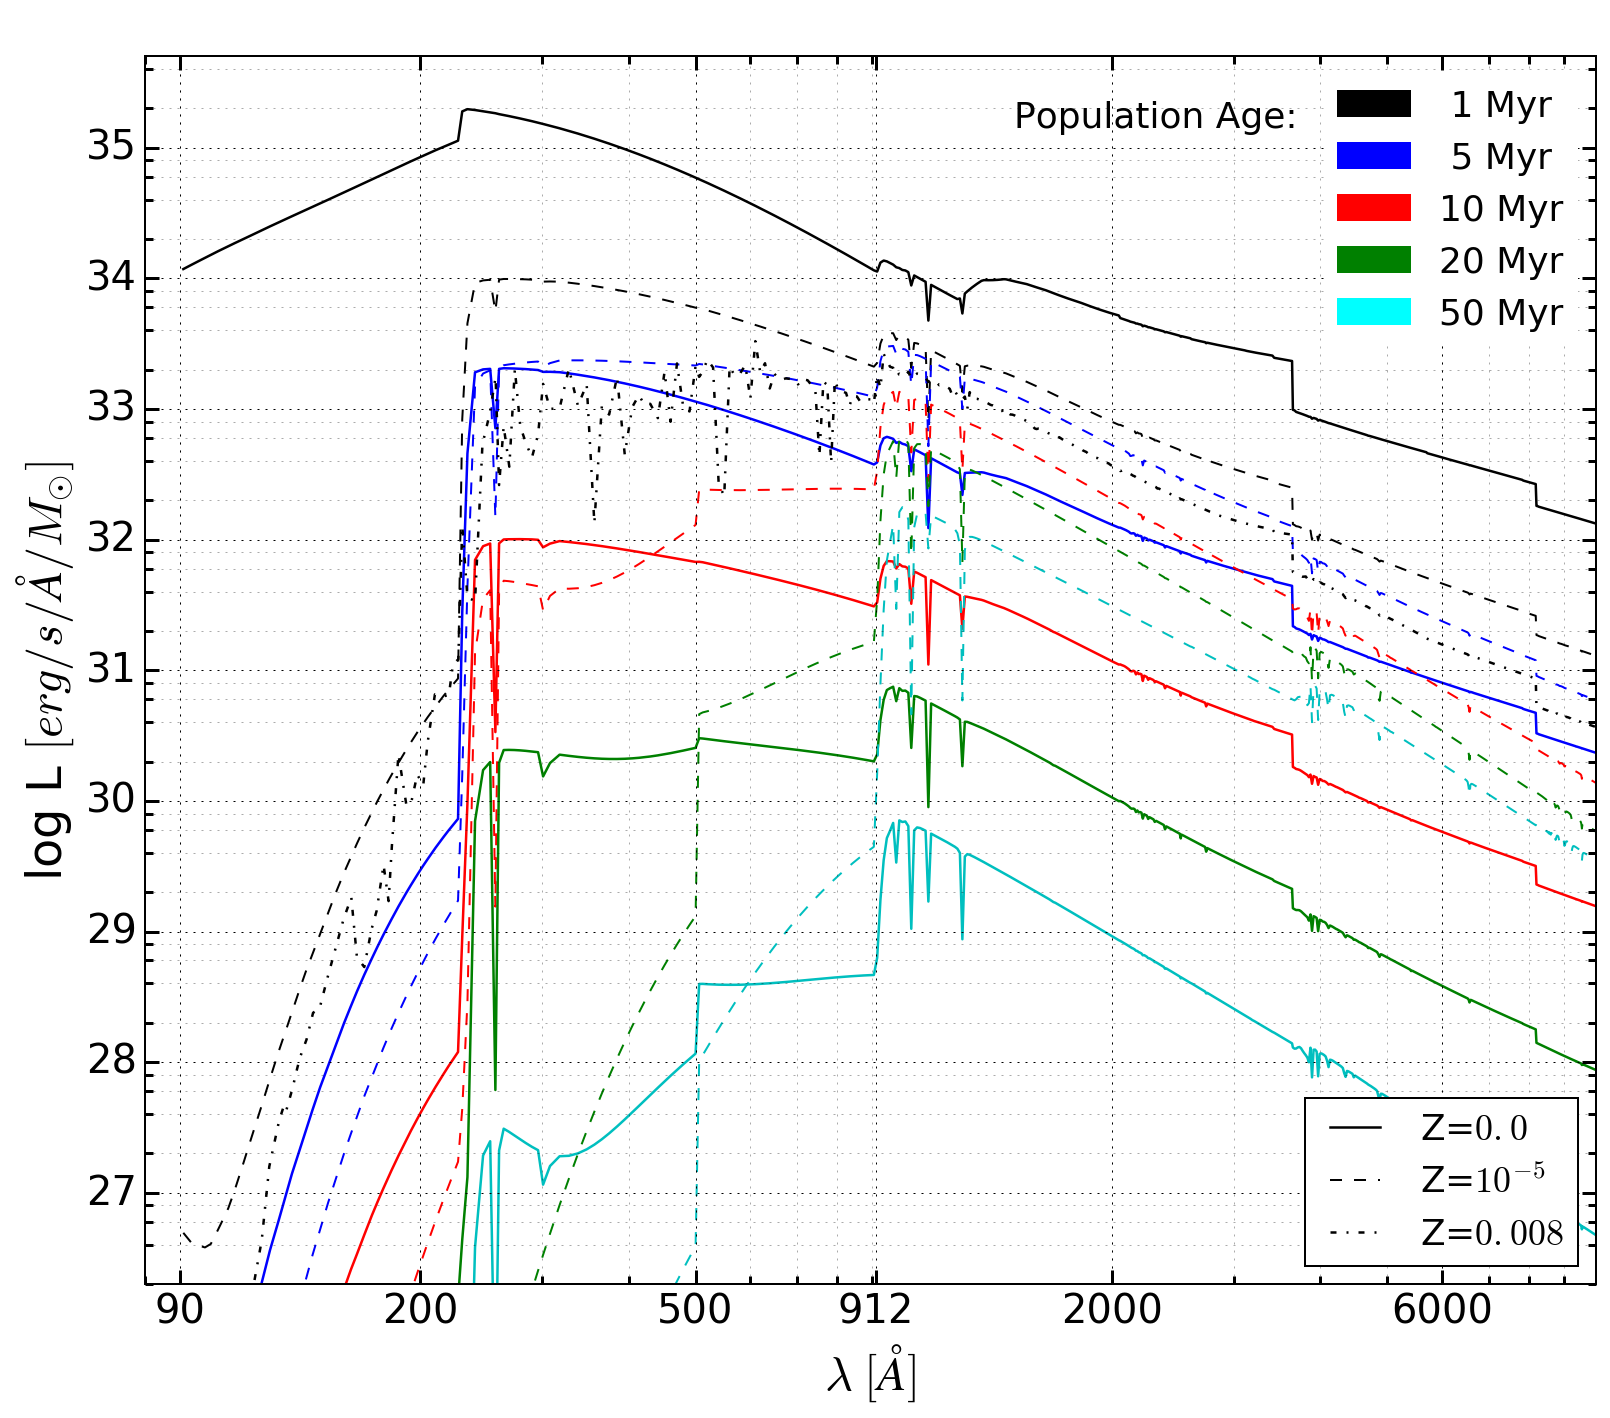

In [35]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(which='both',width=1.5,length=7)
ax.tick_params(which='minor',length=4)

one  = mpatches.Patch(color='black',   label=' 1 Myr')
five = mpatches.Patch(color='blue',    label=' 5 Myr')
ten  = mpatches.Patch(color='red',     label='10 Myr')
twen = mpatches.Patch(color='green',   label='20 Myr')
fift = mpatches.Patch(color='cyan',    label='50 Myr')
keyLeg = plt.legend(loc=1, fontsize=18, handles=[one, five, ten, twen, fift] )
keyLeg.get_frame().set_linewidth(0.0)
plt.gca().add_artist(keyLeg)
ax.annotate('Population Age:',xy=(0.5,0.5),xycoords='figure fraction', textcoords='figure fraction',
               xytext=(0.63,0.91), horizontalalignment='left', size=18)


ax.plot(pop3TE_wl[1],pop3TE_flux[1],'k-',lw=1.25,label='Z=$0.0$')
ax.plot(zem5_wl[1],zem5_flux[1],'k--',label='Z=$10^{-5}$')
ax.plot(pop3TE_wl[5],pop3TE_flux[5],'b-',lw=1.25)
ax.plot(zem5_wl[5],zem5_flux[5],'b--')
ax.plot(pop3TE_wl[10],pop3TE_flux[10],'r-',lw=1.25)
ax.plot(zem5_wl[10],zem5_flux[10],'r--')
ax.plot(pop3TE_wl[20],pop3TE_flux[20],'g-',lw=1.25)
ax.plot(zem5_wl[20],zem5_flux[20],'g--')
ax.plot(pop3TE_wl[50],pop3TE_flux[50],'c-',lw=1.25)
ax.plot(zem5_wl[50],zem5_flux[50],'c--')

ax.plot(SB99008_wl[1],SB99008_flux[1],'k-.',lw=1.25,label='Z=$0.008$')

ax.xaxis.set_major_formatter(intfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([80,1e4])
ax.xaxis.set_ticks([90,200,400,912,2000,6000])
ax.set_ylim([2e26,5e35])

#ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_xlabel(r'$\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")
ax.grid(True,which="minor",ls=":",alpha=0.33)

theLeg = plt.legend(loc=4, fontsize=18 )
theLeg.get_frame().set_linewidth(1.0)
plt.gca().add_artist(theLeg)

#fig.suptitle('Pop III SEDs', fontsize=24)
gc.collect()

In [40]:
gc.collect()

0

In [39]:
gc.collect()

5

77262

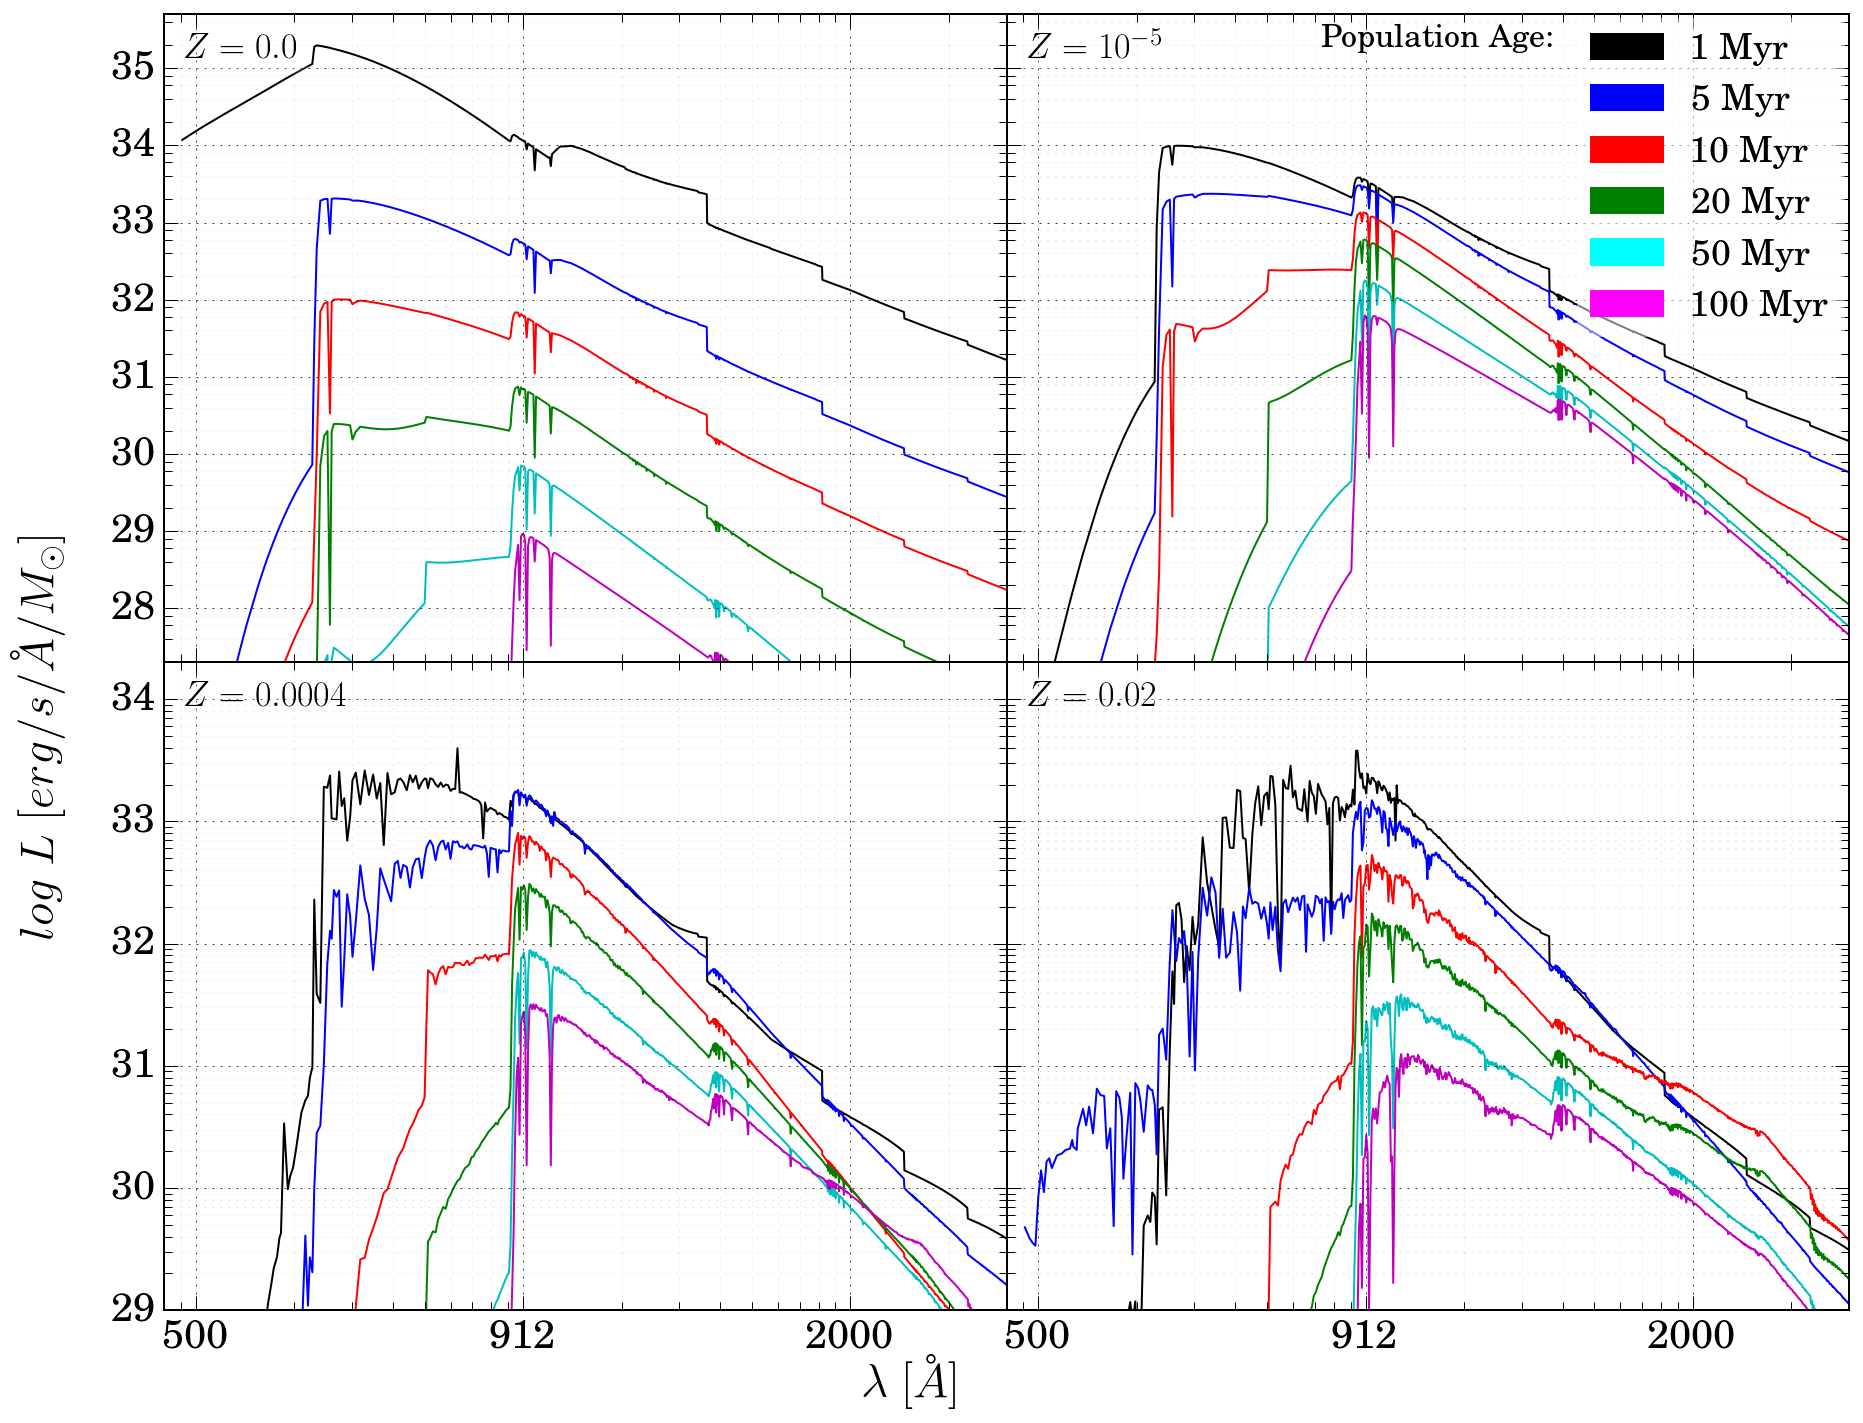

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(13,10))

one  = mpatches.Patch(color='black',   label='  1 Myr')
five = mpatches.Patch(color='blue',    label='  5 Myr')
ten  = mpatches.Patch(color='red',     label=' 10 Myr')
twen = mpatches.Patch(color='green',   label=' 20 Myr')
fift = mpatches.Patch(color='cyan',    label=' 50 Myr')
six  = mpatches.Patch(color='magenta',  label='100 Myr')
figleg = fig.legend([one, five, ten, twen, fift, six], 
                   ('  1 Myr','  5 Myr',' 10 Myr',' 20 Myr',' 50 Myr','100 Myr'), fontsize=18)
figleg.get_frame().set_linewidth(0.0)
figleg.get_frame().set_alpha(0.5)
ax2.annotate('Population Age:',xy=(0.66,0.925),xycoords='axes fraction', ha='right', size=16)


ax1.plot(pop3TE_wl[1],pop3TE_flux[1],'k',lw=1.0, label="$Z=0.0$")
ax1.plot(pop3TE_wl[5],pop3TE_flux[5],'b',lw=1.0)
ax1.plot(pop3TE_wl[10],pop3TE_flux[10],'r',lw=1.0)
ax1.plot(pop3TE_wl[20],pop3TE_flux[20],'g',lw=1.0)
ax1.plot(pop3TE_wl[50],pop3TE_flux[50],'c',lw=1.0)
ax1.plot(pop3TE_wl[100],pop3TE_flux[100],'m',lw=1.0)
ax1.annotate('$Z=0.0$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))
# handles1, labels1 = ax1.get_legend_handles_labels()
# leg = ax1.legend(handles1, labels1,loc=4,fontsize=18)
# leg.get_frame().set_linewidth(0.0)
# leg.get_frame().set_alpha(0.5)

ax2.plot(zem5_wl[1],zem5_flux[1],'k',lw=1.0, label="$Z=10{-5}$")
ax2.plot(zem5_wl[5],zem5_flux[5],'b',lw=1.0)
ax2.plot(zem5_wl[10],zem5_flux[10],'r',lw=1.0)
ax2.plot(zem5_wl[20],zem5_flux[20],'g',lw=1.0)
ax2.plot(zem5_wl[50],zem5_flux[50],'c',lw=1.0)
ax2.plot(zem5_wl[100],zem5_flux[100],'m',lw=1.0)
ax2.annotate('$Z=10^{-5}$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))
# handles2, labels2 = ax2.get_legend_handles_labels()
# leg = ax2.legend(handles2, labels2,loc=4,fontsize=18)
# leg.get_frame().set_linewidth(0.0)
# leg.get_frame().set_alpha(0.5)

ax3.plot(SB990004_wl[1],SB990004_flux[1],'k',lw=1.0, label="$Z=0.0004$")
ax3.plot(SB990004_wl[5],SB990004_flux[5],'b',lw=1.0)
ax3.plot(SB990004_wl[10],SB990004_flux[10],'r',lw=1.0)
ax3.plot(SB990004_wl[20],SB990004_flux[20],'g',lw=1.0)
ax3.plot(SB990004_wl[50],SB990004_flux[50],'c',lw=1.0)
ax3.plot(SB990004_wl[100],SB990004_flux[100],'m',lw=1.0)
ax3.annotate('$Z=0.0004$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))
# handles3, labels3 = ax3.get_legend_handles_labels()
# leg = ax3.legend(handles3, labels3,loc=4,fontsize=18)
# leg.get_frame().set_linewidth(0.0)
# leg.get_frame().set_alpha(0.5)

ax4.plot(SB9902_wl[1],SB9902_flux[1],'k',lw=1.0, label="$Z=0.02$")
ax4.plot(SB9902_wl[5],SB9902_flux[5],'b',lw=1.0)
ax4.plot(SB9902_wl[10],SB9902_flux[10],'r',lw=1.0)
ax4.plot(SB9902_wl[20],SB9902_flux[20],'g',lw=1.0)
ax4.plot(SB9902_wl[50],SB9902_flux[50],'c',lw=1.0)
ax4.plot(SB9902_wl[100],SB9902_flux[100],'m',lw=1.0)
ax4.annotate('$Z=0.02$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))
# handles4, labels4 = ax4.get_legend_handles_labels()
# leg = ax4.legend(handles4, labels4,loc=4,fontsize=18)
# leg.get_frame().set_linewidth(0.0)
# leg.get_frame().set_alpha(0.5)


for a in [ax1,ax2,ax3,ax4]:
    a.set_xscale('log')
    a.set_yscale('log')
    a.tick_params(which='major',length=7)
    a.tick_params(which='minor',length=4)
    a.tick_params(axis='x', labelsize=20)
    a.tick_params(axis='y', labelsize=20)
    a.grid(True,which="major",ls=":",alpha=0.75)
    a.grid(True,which="minor",ls=":",alpha=0.10)

ax1.set_xlim([80,3e4]); ax2.set_xlim([80,3e4]) ; ax3.set_xlim([80,3e4]) ; ax4.set_xlim([80,3e4]) 
ax1.set_ylim([2e27,5e35])
ax2.set_ylim([2e27,5e35])
ax3.set_ylim([1e29,2e34])
ax4.set_ylim([1e29,2e34])

plt.setp([a.get_xticklabels() for a in [ax1,ax2]], visible=False)
plt.setp([a.get_yticklabels() for a in [ax2,ax4]], visible=False)

ax4.xaxis.set_major_formatter(intfmt)
ax3.xaxis.set_major_formatter(intfmt)
ax3.yaxis.set_major_formatter(logfmt) 
ax1.yaxis.set_major_formatter(logfmt) 

ax3.xaxis.set_ticks([90,200,400,912,2000,6000])
ax4.xaxis.set_ticks([90,200,400,912,2000,6000])
ax3.set_xticklabels([90,200,400,912,2000,6000])
ax4.set_xticklabels([90,200,400,912,2000,6000])

fig.text(0.5, 0.04, '$\lambda\; [\AA]$', size=24, ha='center')
fig.text(0.02, 0.5, '$log\; L \;[erg/ s/ \AA/ M_{\odot}]$', size=24, va='center', rotation='vertical')

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("SEDsSqr.pdf",dpi=fig.dpi,bbox_inches='tight')
gc.collect()

81756

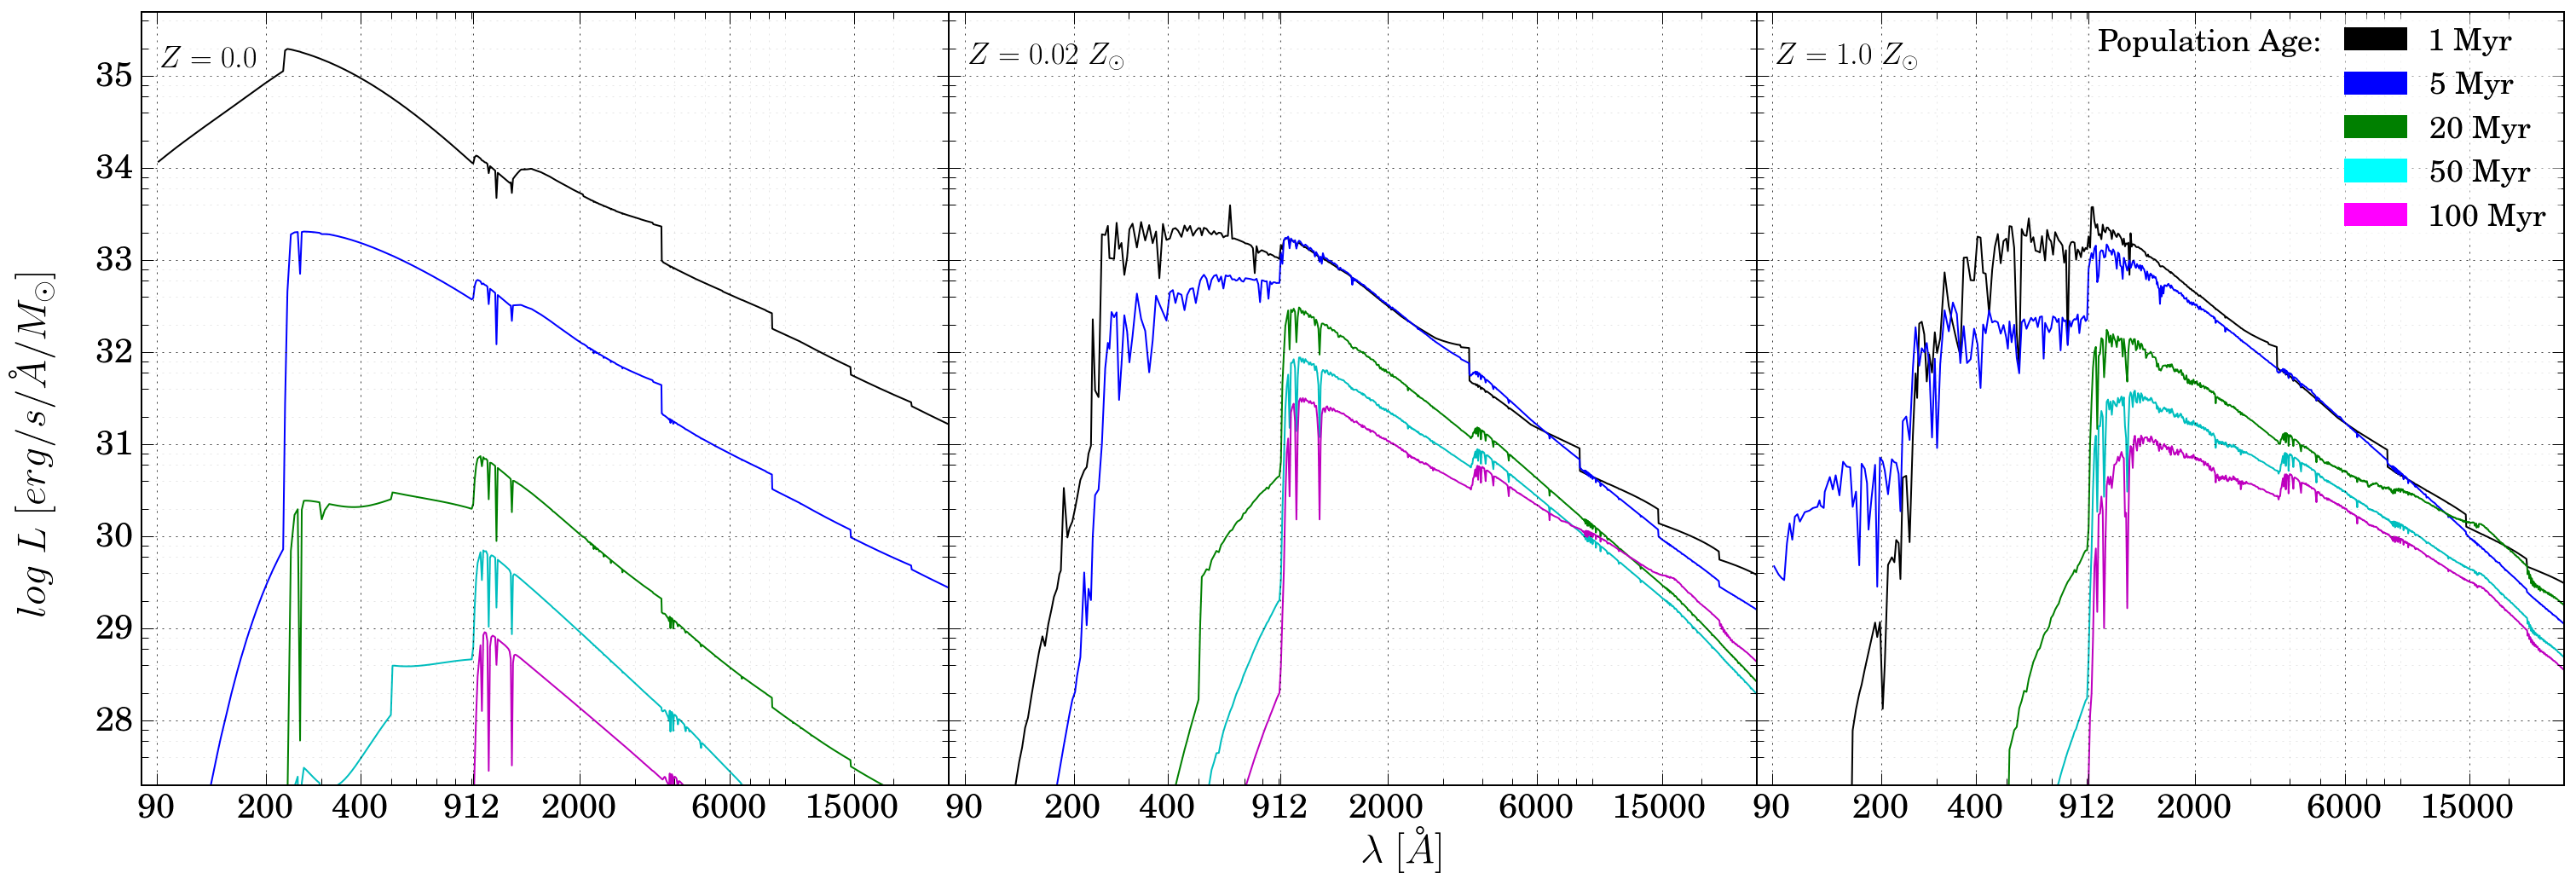

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row',figsize=(21,7))

one  = mpatches.Patch(color='black',   label='  1 Myr')
five = mpatches.Patch(color='blue',    label='  5 Myr')
twen = mpatches.Patch(color='green',   label=' 20 Myr')
fift = mpatches.Patch(color='cyan',    label=' 50 Myr')
six  = mpatches.Patch(color='magenta',  label='100 Myr')
figleg = fig.legend([one, five, twen, fift, six], 
                   ('  1 Myr','  5 Myr',' 20 Myr',' 50 Myr','100 Myr'), fontsize=18)
figleg.get_frame().set_linewidth(0.0)
figleg.get_frame().set_alpha(0.5)
ax3.annotate('Population Age:',xy=(0.70,0.95),xycoords='axes fraction', ha='right', size=18)


ax1.plot(pop3TE_wl[1],pop3TE_flux[1],'k',lw=1.0, label="$Z=0.0$")
ax1.plot(pop3TE_wl[5],pop3TE_flux[5],'b',lw=1.0)
ax1.plot(pop3TE_wl[20],pop3TE_flux[20],'g',lw=1.0)
ax1.plot(pop3TE_wl[50],pop3TE_flux[50],'c',lw=1.0)
ax1.plot(pop3TE_wl[100],pop3TE_flux[100],'m',lw=1.0)
ax1.annotate('$Z=0.0$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))

ax2.plot(SB990004_wl[1],SB990004_flux[1],'k',lw=1.0, label="$Z=0.0004$")
ax2.plot(SB990004_wl[5],SB990004_flux[5],'b',lw=1.0)
ax2.plot(SB990004_wl[20],SB990004_flux[20],'g',lw=1.0)
ax2.plot(SB990004_wl[50],SB990004_flux[50],'c',lw=1.0)
ax2.plot(SB990004_wl[100],SB990004_flux[100],'m',lw=1.0)
ax2.annotate('$Z=0.02\; Z_{\odot}$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))

ax3.plot(SB9902_wl[1],SB9902_flux[1],'k',lw=1.0, label="$Z=0.02$")
ax3.plot(SB9902_wl[5],SB9902_flux[5],'b',lw=1.0)
ax3.plot(SB9902_wl[20],SB9902_flux[20],'g',lw=1.0)
ax3.plot(SB9902_wl[50],SB9902_flux[50],'c',lw=1.0)
ax3.plot(SB9902_wl[100],SB9902_flux[100],'m',lw=1.0)
ax3.annotate('$Z=1.0\; Z_{\odot}$', xy=(0.025,0.92), xycoords='axes fraction',
            size=18, ha='left', va='bottom',
            bbox=dict(boxstyle=None, fc='w', edgecolor='None', alpha=0.15))
# handles4, labels4 = ax4.get_legend_handles_labels()
# leg = ax4.legend(handles4, labels4,loc=4,fontsize=18)
# leg.get_frame().set_linewidth(0.0)
# leg.get_frame().set_alpha(0.5)


for a in [ax1,ax2,ax3]:
    a.set_xscale('log')
    a.set_yscale('log')
    a.tick_params(which='major',length=7)
    a.tick_params(which='minor',length=4)
    a.tick_params(axis='x', labelsize=20)
    a.tick_params(axis='y', labelsize=20)
    a.grid(True,which="major",ls=":",alpha=0.75)
    a.grid(True,which="minor",ls=":",alpha=0.10)

ax1.set_xlim([80,3e4]); ax2.set_xlim([80,3e4]) ; ax3.set_xlim([80,3e4]) 
ax1.set_ylim([2e27,5e35])
ax2.set_ylim([2e27,5e35])
ax3.set_ylim([2e27,5e35])

plt.setp([a.get_yticklabels() for a in [ax2,ax3]], visible=False)

ax1.xaxis.set_major_formatter(intfmt)
ax2.xaxis.set_major_formatter(intfmt)
ax3.xaxis.set_major_formatter(intfmt)
ax1.yaxis.set_major_formatter(logfmt) 
# ax2.yaxis.set_major_formatter(logfmt) 
# ax3.yaxis.set_major_formatter(logfmt) 

ax1.xaxis.set_ticks([90,200,400,912,2000,6000,15000])
ax2.xaxis.set_ticks([90,200,400,912,2000,6000,15000])
ax3.xaxis.set_ticks([90,200,400,912,2000,6000,15000])

ax1.set_xticklabels([90,200,400,912,2000,6000,15000])
ax2.set_xticklabels([90,200,400,912,2000,6000,15000])
ax3.set_xticklabels([90,200,400,912,2000,6000,15000])

fig.text(0.01, 0.5, '$log\; L \;[erg/ s/ \AA/ M_{\odot}]$', size=24, va='center', rotation='vertical')
fig.text(0.55, 0.01, '$\lambda\; [\AA]$', size=24, ha='center')

plt.subplots_adjust(left=0.06, bottom=0.1, right=1.0, top=1.0, wspace=.0, hspace=.0)
plt.savefig("SEDs.pdf",dpi=fig.dpi,bbox_inches='tight')
gc.collect()